# KEY TAKEAWAYS

1. <b>Intro:</b> Since our domain is business intelligence for improving tele-marketing strategy, we will focus heavily on feature importance to understand which factors play a bigger role in making the sale. 


2. <b>Overview of methods:</b> We tried three different feature importance methods: drop column, permutation and RFPimp's importance algorithm (which basically implements permutation?). We can see from the heat map that alot of the features are correlated/codependent. Therefore we decided to use the RFPimp implementation as it allows us to consider multiple features together. It avoids showing low importance for codependent features as with drop column, or having codepedent features share importance scores as with permutation.


3. <b>Interpret results:</b> The RFPimp results show <b>nr.employed, cons.conf.indx, euribor3m, month_oct</b> as the most important features. We notice that the top three features are all economic indicators. This finding may have business implications, for example:

    - Telemarketing might just not be effective in bad economic conditions and the bank should try different marketing techniques.
    - The bank should collect more economic indicators as they seem to be important factors in whether a sale is made.


4. <b>Next steps:</b> Our pipelines current model using all features, our next steps are to do more feature selection based on the results of these feature importance algorithms and to rerun our models to see if we can improve f1 score. 

<b>Potential visuals:</b>
![](file.svg)
![](heatmap.svg)

In [ ]:
# recommendation: collect more economic indicators as these are important features
# we modeled it using all features, now do feature importance
# next step: rerun models with more feature selection with these results
# back to business case: 
# big conclusion: moving the PR curve 
# telemarketing might not work in bad economic conditions, should 

In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rfpimp import *

In [71]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

# Load data

In [84]:
# Features data, drop y and Duration.
X = df.drop(['duration','y'], axis=1)
# Encode dummies.
#X.replace(['yes', 'no'], ['1', '0'], inplace=True)
# One-hot encode categorical features.
X = pd.get_dummies(X)
# Labels data.
y = df['y']
y = y.map({'no': 0, 'yes': 1})

In [85]:
X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


# Train test split

In [86]:
# Train-test-split on data.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [87]:
numeric_features = ['age', 'campaign', 'cons.price.idx', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
                            'euribor3m', 'nr.employed']
categorical_features = ['job', 'education', 'default', 'housing',
                            'loan', 'campaign', 'poutcome', 'marital', 'contact', 'month', 'day_of_week']
    

# EDIT: feature importance metric is model.score()

    The model.score() method is called to measure accuracy drops.
    
    This version that computes accuracy drops with the validation set
    is much faster than the OOB, cross validation, or drop column
    versions. The OOB version is a less vectorized because it needs to dig
    into the trees to get out of examples. The cross validation and drop column
    versions need to do retraining and are necessarily much slower.
    
    This function used OOB not validation sets in 1.0.5; switched to faster
    test set version for 1.0.6. (breaking API change)

# Method 1: Drop Column 

<b>Drop-column pros/cons</b>

• Easy to understand

• Simple to implement

• Very direct means of measuring importance

• Works for any machine learning model

• BUT, very expensive because it means retraining the model p
times for p features; try on a subset of the data for speed

• Codependent features often result in 0 or very low importance

In [88]:
# drop column
def dropcol_importances(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    baseline = model.score(X_val, y_val)
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X, y_train)
        m = model_.score(X_val.drop(col,axis=1), y_val)
        imp.append(baseline - m)
        
    # create df with feature name and importance (from rfpimp)
    labels = []
    for col in X_train.columns:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I


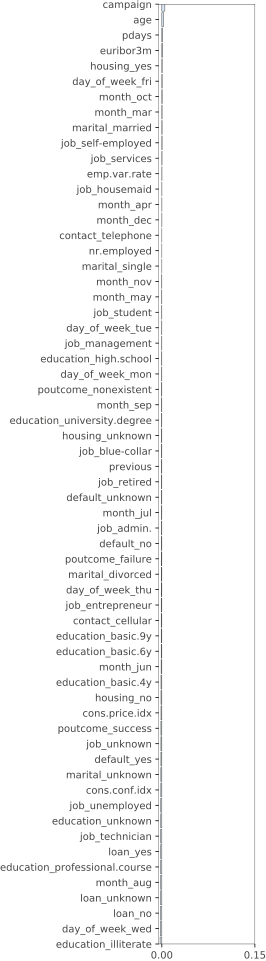

In [89]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, oob_score=True) # default n_estimates = 10
imp_drop = dropcol_importances(rf, X_train, y_train, X_val, y_val)
plot_importances(imp_drop)

# Method 2: Permutation

<b>Permutation importance pros/cons</b>

• Easy to understand

• Simple to implement

• Works for any machine learning model

• No need to retrain the model so much more efficient than drop
column importance

• Can create nonsensical records through permutation, such as
pregnant male, which makes the results suspect

• Codependent features often share importance, such as longitude
and latitude

• Strobl et al “permutation importance over-estimates the importance of correlated predictor variables”

In [56]:
# permutation
def permutation_importances(model, X_train, y_train, X_val, y_val):
    
    X_sample, y_sample, _ = sample(X_train, y_train, n_samples=5000) #
    
    model.fit(X_train, y_train)
    baseline = model.score(X_val, y_val)
    X_train = X_sample.copy(deep=False) # shallow copy #
    y_train = y_sample #
    
    imp = []
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = model.score(X_val, y_val)
        X_val[col] = save
        imp.append(baseline - m)
        
    # create df with feature name and importance(from rfpimp)
    labels = []
    for col in X_val.columns:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

In [57]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, oob_score=True)
imp_perm = permutation_importances(rf, X_train, y_train, X_val, y_val)

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lisachua/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

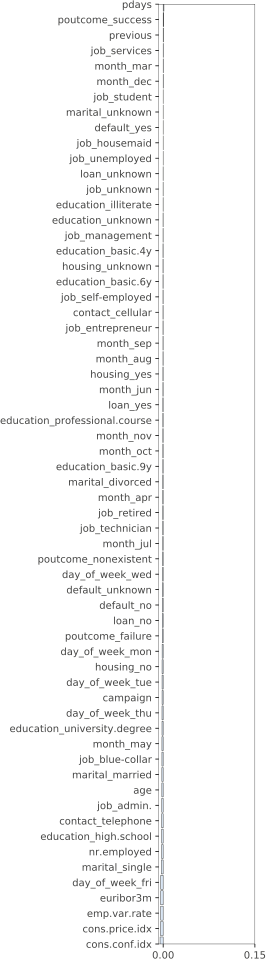

In [58]:
plot_importances(imp_perm)

# RFPIMP

<b>Codependent features</b>

• Drop column and permutation importance consider each feature
individually, though my rfpimp package lets you consider multiple
features together

• If all features are totally independent, then computing feature
importance individually is no problem

• If, however, two or more features are codependent (correlated in
some way but not necessarily with a strictly linear relationship)
computing feature importance individually can give unexpected results

• Drop-column tends to show low importance scores and permutation
tends to share importance scores for codependent features

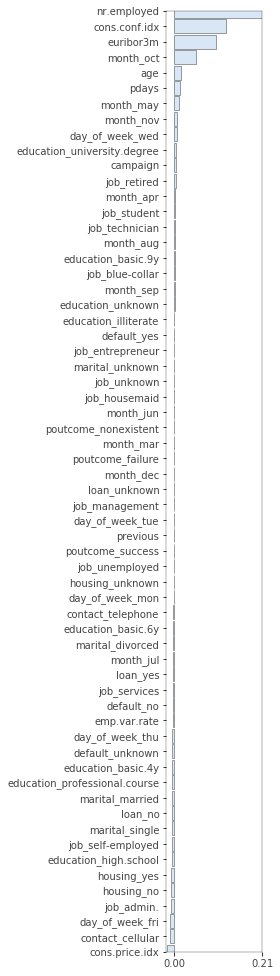

In [61]:
# RFPIMP
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
imp_rfpimp = importances(rf, X_val, y_val)
viz = plot_importances(imp_rfpimp)
viz.save('file.svg')
#viz.save('file.pdf')
viz.view() # view viz in notebook

# Heatmap for detecting collinear features

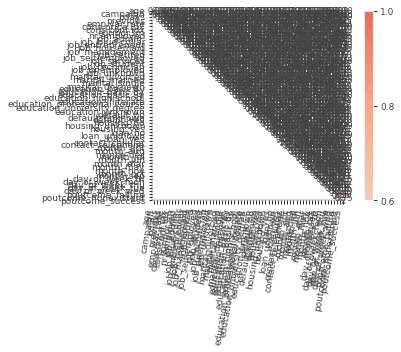

In [91]:
# RFPIMP heatmap sucks
df_train = feature_corr_matrix(X_train)
heatmap = plot_corr_heatmap(df_train, figsize=(7,5))
heatmap.view()

In [99]:
# Prettier heatmap still sucks
import seaborn as sns

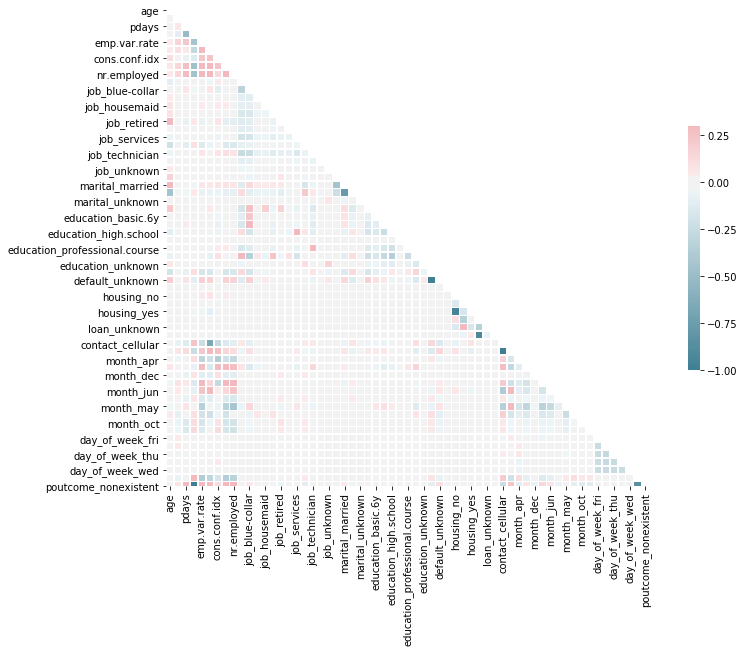

In [100]:
# This one is not the worst!
mask = np.zeros_like(df_train, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#plt.figure(figsize = (20,20))
sns.heatmap(df_train, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heatmap.svg')

# DISCARD: Feature importance metric: OOB accuracy for scikit-learn RF classifier.

In [26]:
def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

# drop column
def dropcol_importances(model, X_train, y_train, metric):
    model.fit(X_train, y_train)
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X, y_train)
        m = metric(model_, X, y_train)
        imp.append(baseline - m)
        
    # create df with feature name and importance (from rfpimp)
    labels = []
    for col in X_train.columns:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I
